# Import Libraries

In [1]:
# Common imports
import os
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image

## Set Some Parameters

In [3]:
# Dataset information

# Test dataset is set explicitly, because the amount of data is very small
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width = 250, 250  # size of images
num_classes = 2  # me - not_me

# Training settings
validation_ratio = 0.15  # 15% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

## Create Dataset

### Read datasets from folders

In [4]:
# Train and validation sets
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 195 files belonging to 2 classes.
Using 166 files for training.
Found 195 files belonging to 2 classes.
Using 29 files for validation.


In [5]:
# Test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 20 files belonging to 2 classes.


In [6]:
class_names = test_ds.class_names
class_names

['me', 'not_me']

# Build The Model (ResNet50)

In [7]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

In [8]:
# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

face_classifier = keras.models.Model(inputs=base_model.input,
                                     outputs=output,
                                     name='ResNet50')
face_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [11]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

# Training

In [12]:
epochs = 50

In [13]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save("models/face_classifier.h5")

Epoch 1/50
11/11 [==============================] - 12s 870ms/step - loss: 2.3710 - accuracy: 0.6024 - val_loss: 0.3427 - val_accuracy: 0.8276

Epoch 00001: val_loss improved from inf to 0.34269, saving model to models\face_classifier.h5


C:\Users\Dmytro\Anaconda3\envs\tenv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
11/11 [==============================] - 9s 853ms/step - loss: 0.4234 - accuracy: 0.8554 - val_loss: 0.3930 - val_accuracy: 0.8276

Epoch 00002: val_loss did not improve from 0.34269
Epoch 3/50
11/11 [==============================] - 10s 938ms/step - loss: 0.1695 - accuracy: 0.9337 - val_loss: 0.3767 - val_accuracy: 0.8276

Epoch 00003: val_loss did not improve from 0.34269
Epoch 4/50
11/11 [==============================] - 10s 921ms/step - loss: 0.0781 - accuracy: 0.9699 - val_loss: 0.3084 - val_accuracy: 0.8966

Epoch 00004: val_loss improved from 0.34269 to 0.30842, saving model to models\face_classifier.h5
Epoch 5/50
11/11 [==============================] - 10s 933ms/step - loss: 0.0457 - accuracy: 0.9819 - val_loss: 0.2983 - val_accuracy: 0.9310

Epoch 00005: val_loss improved from 0.30842 to 0.29832, saving model to models\face_classifier.h5
Epoch 6/50
11/11 [==============================] - 10s 899ms/step - loss: 0.0262 - accuracy: 0.9940 - val_loss: 0.2823 - val_a

# Testing

In [14]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=250, class_names=['me', 'not_me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [15]:
model_name = 'face_classifier.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [16]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/me',
                                  y_true='me')

correct - me_(12).jpg
	me     with probabily of 74.51%
	not_me with probabily of 21.41%
correct - me_(14).jpg
	me     with probabily of 99.85%
	not_me with probabily of 0.16%
incorrect - me_(27).jpg
	me     with probabily of 45.02%
	not_me with probabily of 62.32%
correct - me_(31).jpg
	me     with probabily of 53.36%
	not_me with probabily of 2.27%
correct - me_(36).jpg
	me     with probabily of 96.14%
	not_me with probabily of 0.62%
correct - me_(44).jpg
	me     with probabily of 99.48%
	not_me with probabily of 0.55%
correct - me_(53).jpg
	me     with probabily of 88.09%
	not_me with probabily of 18.36%
correct - me_(58).jpg
	me     with probabily of 96.12%
	not_me with probabily of 6.19%
correct - me_(69).jpg
	me     with probabily of 63.42%
	not_me with probabily of 31.29%
correct - me_(8).jpg
	me     with probabily of 90.76%
	not_me with probabily of 2.07%

Total accuracy is 90.00% = 9/10 samples classified correctly


In [17]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/not_me',
                                  y_true='not_me')

incorrect - brother_(16).jpg
	me     with probabily of 89.34%
	not_me with probabily of 7.86%
incorrect - brother_(2).jpg
	me     with probabily of 49.04%
	not_me with probabily of 39.83%
correct - father_(2).jpg
	me     with probabily of 7.13%
	not_me with probabily of 88.36%
correct - father_(5).jpg
	me     with probabily of 4.67%
	not_me with probabily of 92.88%
correct - mother_(20).jpg
	me     with probabily of 9.15%
	not_me with probabily of 91.01%
correct - mother_(5).jpg
	me     with probabily of 4.61%
	not_me with probabily of 85.92%
correct - other.jpg
	me     with probabily of 1.65%
	not_me with probabily of 98.90%
correct - sister_(2).jpg
	me     with probabily of 0.91%
	not_me with probabily of 95.94%
correct - sister_(44).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - sister_(47).jpg
	me     with probabily of 0.01%
	not_me with probabily of 99.99%

Total accuracy is 80.00% = 8/10 samples classified correctly


## Test of particular image

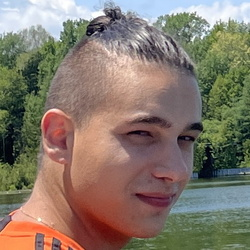

In [18]:
test_path = 'datasets/face_dataset_test_images/me/me_(69).jpg'
test_image = image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [19]:
test_image = image.img_to_array(test_image)  # from image to array
# shape from (250, 250, 3) to (1, 250, 250, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

me     with probabily of 63.42%
not_me with probabily of 31.29%
